# Image classification with CNN
In this notebook we will experiment with classifying images of cats and dogs using Convolutional Neural Networks. 
The input dataset consists of 10,000 images manually labeled as ''cats'' and ''dogs''. This is the same dataset as in the logistic regression demo [folder](https://drive.google.com/file/d/1rjv0hlg6dcn0vMByikYfWpqpkk2vxtXA/view?usp=sharing). The preprocessing is the same as before.

__The difference with the other noebook__ is that we shuffle the training set using `shuffle=True` parameter to  `model.fit()`. This  is recommended in [this post](https://www.kaggle.com/general/159828).

As you can see by the final results, this did not help much.

## 1. Data preprocessing
Exactly thee same as before.

### Import all the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from keras import preprocessing

import sys
import os

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

### Load images

In [2]:
cwd = os.getcwd()
os.chdir(cwd)

data_dir = "../data_sets/cat_dog_data"
print(os.listdir(data_dir))

['test_set', 'training_set']


In [3]:
train_cats_files = []
train_path_cats = data_dir +"/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        train_cats_files.append(os.path.join(train_path_cats, path))
        
train_dogs_files = []
train_path_dogs = data_dir +"/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        train_dogs_files.append(os.path.join(train_path_dogs, path))
        
print(len(train_cats_files), len(train_dogs_files))

test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if ".jpg" in path:
        test_cats_files.append(os.path.join(test_path_cats,path))

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))

print(len(test_cats_files), len(test_dogs_files))

4000 4000
1000 1000


In [4]:
k = 200
sample_dog_file = train_dogs_files[k]
img = preprocessing.image.load_img(sample_dog_file, target_size=(64, 64))
img_array = preprocessing.image.img_to_array(img)

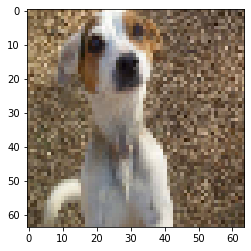

In [5]:
plt.imshow(np.uint8(img_array))

### Converting images to numpy arrays
Now we create training and testing sets for cats and for dogs and then concatenate them into a single `X_train`, `X_test` dataset of features.

In [6]:
d = 32
X_train_orig = np.zeros((8000, d, d, 3), dtype='float32')
for i in range(4000):    
    path = train_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)

for i in range(4000,8000):    
    path = train_dogs_files[i-4000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)    

    X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')

for i in range(1000):
    img = preprocessing.image.load_img(test_cats_files[i], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)
    
for i in range(1000, 2000):
    img = preprocessing.image.load_img(test_dogs_files[i-1000], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

print(X_train_orig.shape)
print(X_test_orig.shape)

(8000, 32, 32, 3)
(2000, 32, 32, 3)


### Normalizing image array

In [7]:
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0
print(X_train.shape)
print(X_test.shape)

(8000, 32, 32, 3)
(2000, 32, 32, 3)


### Adding class labels
Now we need to create the corresponding class label vectors. We will mark the cats as class 1, and the dogs as class 0 (not cats).

In [8]:
# class labels for train data

Y_train_orig = np.ones((4000,)) # 1 - 4000 are cat pictures so our label is 1
Y_train_orig = np.concatenate((Y_train_orig, np.zeros((4000,)))) # 4000 - 8000 are dog pictures so our label is 0

print(Y_train_orig)

Y_train = Y_train_orig.reshape(-1)
print(Y_train)
print("At position 3 should be a cat:", Y_train[3])
print("At position 4002 should be a dog:", Y_train[4002])
Y_train.shape

[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
At position 3 should be a cat: 1.0
At position 4002 should be a dog: 0.0


(8000,)

### Repeating the same steps for the test set

In [9]:
test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if '.jpg' in path:
        test_cats_files.append(os.path.join(test_path_cats, path))
        

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))
        

len(test_cats_files), len(test_dogs_files)

(1000, 1000)

In [10]:
X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')  

for i in range(1000):    
    path = test_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

for i in range(1000,2000):    
    path = test_dogs_files[i-1000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)    


X_test_orig.shape

(2000, 32, 32, 3)

In [11]:
# normalize test data
X_test = X_test_orig / 255.0

In [12]:
# create class label for test set
Y_test_orig = np.ones((1000,)) # 1 - 1000 are cat so label = 1
Y_test_orig = np.concatenate((Y_test_orig, np.zeros((1000,)))) # 1000 - 2000 are dog so label = 0

Y_test = Y_test_orig.reshape(-1)
Y_test.shape

(2000,)

## 2. Experimenting with CNN architecture

### Experiment 1
6-layer network
- One Convolution layer 
- Max Pool
- Dropout
- Flatten: to combine all the filters into a single layer
- Dense with 32 nodes
- Dense output layer with a single neuron: activation function is sigmoid

The last three layers stay the same thoughout all the experiments.

The results show that the predictive power of the model stops improving very early achieving about 71% accuracy on the test set.

In [13]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))


# Select the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 10  # for better result increase the epochs
batch_size = 32

# Fit the model. If you want to see the progress, set verbose=True (it is also True by default)
history = model.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                    validation_data = (X_test,Y_test), batch_size=batch_size)

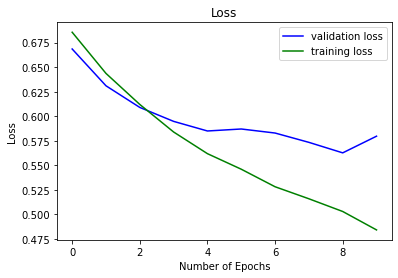

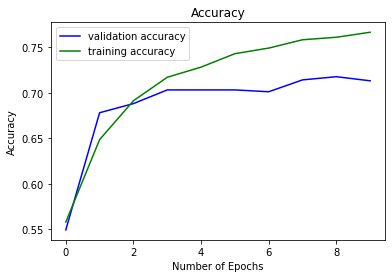

In [14]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='g', label="training loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history.history['accuracy'], color='g', label="training accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### Experiment 2

Adding more convolutional layers.

Two layers of Convolutional filter pairs with max pooling after each pair and Dropout at the end.

The results are better than in Experiment 1. It seems that the model continues learning and improving until epoch 8, reaching about 77% accuracy.

In [15]:
model_2 = Sequential()


model_2.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', 
                 activation ='relu', input_shape = (d,d,3)))

model_2.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', 
                 activation ='relu'))

model_2.add(MaxPool2D(pool_size=(2,2)))


model_2.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same', 
                 activation ='relu'))
model_2.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same', 
                 activation ='relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.2))


# fully connected - this remains the same before output level
model_2.add(Flatten())

model_2.add(Dense(32, activation = "relu"))

model_2.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_2.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 10  # for better result increase the epochs
batch_size = 64

# Fit the model
history_2 = model_2.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

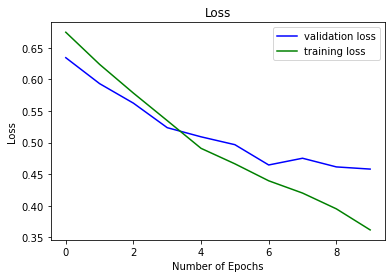

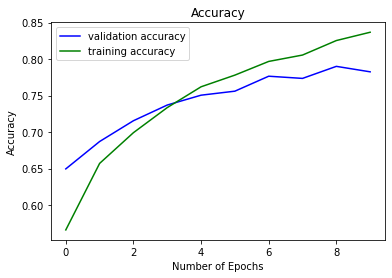

In [16]:
plt.plot(history_2.history['val_loss'], color='b', label="validation loss")
plt.plot(history_2.history['loss'], color='g', label="training loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history_2.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history_2.history['accuracy'], color='g', label="training accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Experiment 3

3 Convolutional layers, with max pooling and dropout after each of them. 

The results are very encouraging. The accuracy continues increasing, and the loss is decreasing.

We need to try to run more epochs.

In [17]:
model_3 = Sequential()


model_3.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same', 
                 activation ='relu'))

model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters = 128, kernel_size = (3,3), padding='same', 
                 activation ='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))



# fully connected
model_3.add(Flatten())

model_3.add(Dense(512, activation = "relu"))

model_3.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_3.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 10  # for better result increase the epochs
batch_size = 128

# Fit the model
history_3 = model_3.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

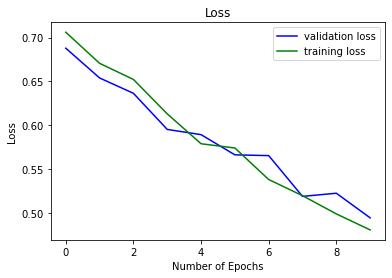

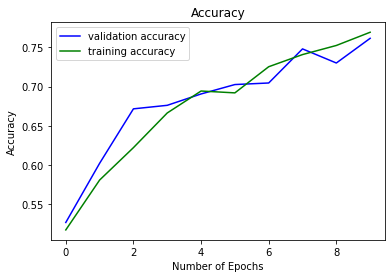

In [18]:
plt.plot(history_3.history['val_loss'], color='b', label="validation loss")
plt.plot(history_3.history['loss'], color='g', label="training loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history_3.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history_3.history['accuracy'], color='g', label="training accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Experiment 3A

Same as Experiment 3, but more learning epochs.

Test accuracy stops improving after about 17 epochs.

In [19]:
model_3 = Sequential()


model_3.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters = 64, kernel_size = (3,3), padding='same', 
                 activation ='relu'))

model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(filters = 128, kernel_size = (3,3), padding='same', 
                 activation ='relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))



# fully connected
model_3.add(Flatten())

model_3.add(Dense(512, activation = "relu"))

model_3.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_3.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 20  # for better result increase the epochs
batch_size = 128

# Fit the model
history_3 = model_3.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

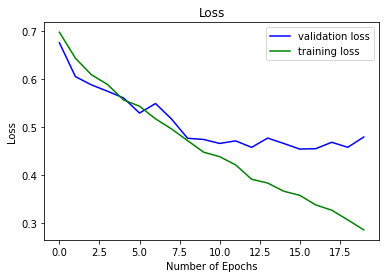

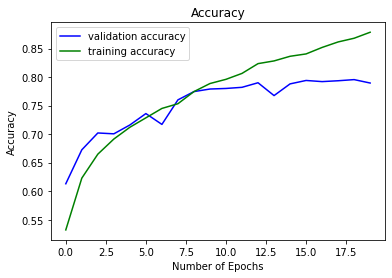

In [20]:
plt.plot(history_3.history['val_loss'], color='b', label="validation loss")
plt.plot(history_3.history['loss'], color='g', label="training loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history_3.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history_3.history['accuracy'], color='g', label="training accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Experiment 4

Adding Dropout layer between last two layers.

In [21]:
model_4 = Sequential()

model_4.add(Conv2D(filters = 32, kernel_size = (3,3),padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))


model_4.add(Conv2D(filters = 64, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))


model_4.add(Conv2D(filters = 128, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))



# fully connected
model_4.add(Flatten())

model_4.add(Dense(256, activation = "relu"))
model_4.add(Dropout(0.5))

model_4.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_4.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 20  
batch_size = 128

# Fit the model
history_4 = model_4.fit(X_train, Y_train, epochs = epochs, verbose = False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

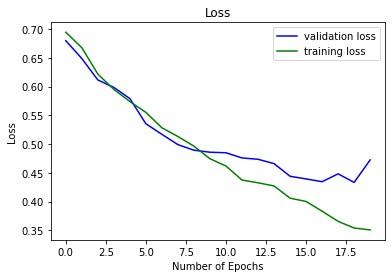

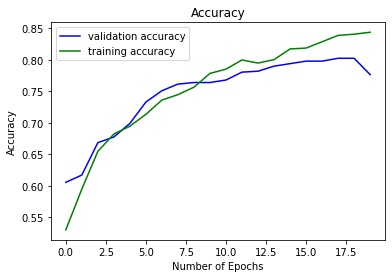

In [22]:
plt.plot(history_4.history['val_loss'], color='b', label="validation loss")
plt.plot(history_4.history['loss'], color='g', label="training loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history_4.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history_4.history['accuracy'], color='g', label="training accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Experiment 5

Same architecture as in Experiment 4.
We try to make smaller batches and continue for more iterations.

The result is that at iteration 8 the model achieves the best accuracy on testing set.

In [23]:
model_5 = Sequential()

model_5.add(Conv2D(filters = 32, kernel_size = (3,3),padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))


model_5.add(Conv2D(filters = 64, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))


model_5.add(Conv2D(filters = 128, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

# fully connected
model_5.add(Flatten())

model_5.add(Dense(256, activation = "relu"))
model_5.add(Dropout(0.5))

model_5.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_5.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 20  
batch_size = 64

# Fit the model
history_5 = model_5.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

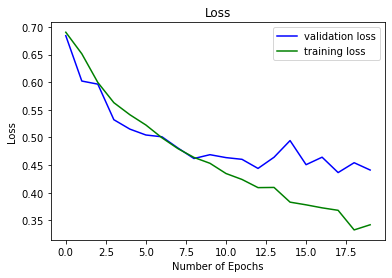

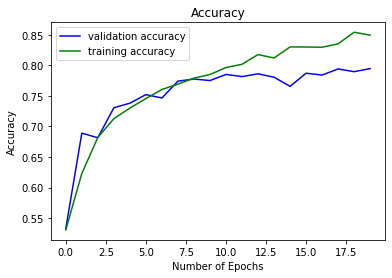

In [24]:
plt.plot(history_5.history['val_loss'], color='b', label="validation loss")
plt.plot(history_5.history['loss'], color='g', label="training loss")
plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history_5.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history_5.history['accuracy'], color='g', label="training accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Conclusion
The best model is either Model 4 or Model 5. 

In [25]:
accuracy = history_4.history['val_accuracy'][12]
print(f'It achieved {accuracy:.3} on both training and testing sets after 13 iterations')

It achieved 0.782 on both training and testing sets after 13 iterations


In [26]:
accuracy = history_5.history['val_accuracy'][14]
print(f'It achieved {accuracy:.3} on both training and testing sets after 15 iterations')

It achieved 0.766 on both training and testing sets after 15 iterations


Both models seem good. So we rebuild them with early stopping - for further use.

In [27]:
model_4 = Sequential()

model_4.add(Conv2D(filters = 32, kernel_size = (3,3),padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))


model_4.add(Conv2D(filters = 64, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))


model_4.add(Conv2D(filters = 128, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))



# fully connected
model_4.add(Flatten())

model_4.add(Dense(256, activation = "relu"))
model_4.add(Dropout(0.5))

model_4.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_4.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 13 
batch_size = 128

# Fit the model
history_4 = model_4.fit(X_train, Y_train, epochs = epochs, verbose = False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

In [28]:
model_5 = Sequential()

model_5.add(Conv2D(filters = 32, kernel_size = (3,3),padding='same', 
                 activation ='relu', input_shape = (d,d,3)))
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))


model_5.add(Conv2D(filters = 64, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))


model_5.add(Conv2D(filters = 128, kernel_size = (3,3),padding='same', 
                 activation ='relu'))
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.25))

# fully connected
model_5.add(Flatten())

model_5.add(Dense(256, activation = "relu"))
model_5.add(Dropout(0.5))

model_5.add(Dense(1, activation = "sigmoid"))


# Define the optimizer
# lr = learning rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model_5.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

epochs = 15  
batch_size = 64

# Fit the model
history_5 = model_5.fit(X_train, Y_train, epochs = epochs, verbose=False, shuffle=True,
                        validation_data = (X_test,Y_test), batch_size=batch_size)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


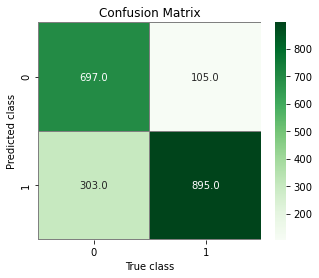

In [29]:
# confusion matrix
import seaborn as sns

# Predict the values from the validation dataset
Y_pred = model_5.predict_classes(X_test) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_pred, Y_test ) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

## My cats and dogs: reality check

In [30]:
new_cats_path = "../data_sets/new_set/cats"
new_dogs_path = "../data_sets/new_set/dogs"

new_cats_files = []
new_dogs_files = []

for path in os.listdir(new_cats_path):
    if '.jpg' in path:
        new_cats_files.append(os.path.join(new_cats_path, path))
        
new_dogs_files = []
for path in os.listdir(new_dogs_path):
    if '.jpg' in path:
        new_dogs_files.append(os.path.join(new_dogs_path, path))
        
print(len(new_cats_files), len(new_dogs_files))

5 5


In [31]:
d = 32
img_arr = np.zeros((10, d, d, 3), dtype='float32')
for i in range(5):    
    path = new_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    img_arr[i] = preprocessing.image.img_to_array(img)

for i in range(5,10):    
    path = new_dogs_files[i-5]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    img_arr[i] = preprocessing.image.img_to_array(img) 

In [32]:
X_all = img_arr / 255.0

print(X_all.shape)

(10, 32, 32, 3)


In [33]:
Y_predict_new_img = model_4.predict(X_all) 
print(Y_predict_new_img)

Y_labels = np.rint(Y_predict_new_img)
#print(Y_labels)

[[0.3706613 ]
 [0.3174853 ]
 [0.8502279 ]
 [0.8858055 ]
 [0.56784815]
 [0.5982839 ]
 [0.00301379]
 [0.759439  ]
 [0.50822926]
 [0.7067536 ]]


<Figure size 432x288 with 0 Axes>

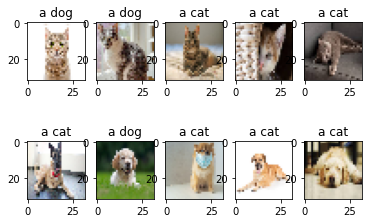

In [34]:
classes = ['dog','cat']

plt.figure()
f, axarr = plt.subplots(ncols=5, nrows=2) 

k = 0
for i in range(2):
    for j in range(5):
        axarr[i][j].imshow(np.uint8(img_arr[k]))      
        axarr[i][j].set_title("a "+classes[int(Y_labels[k])])
        k += 1

In [35]:
Y_predict_new_img = model_5.predict(X_all) 
print(Y_predict_new_img)

Y_labels = np.rint(Y_predict_new_img)
#print(Y_labels)

[[8.2803130e-02]
 [3.5615683e-01]
 [8.8484955e-01]
 [8.1108069e-01]
 [7.0922214e-01]
 [7.0865124e-01]
 [3.0233068e-05]
 [8.8285661e-01]
 [2.8989762e-01]
 [4.7840241e-01]]


<Figure size 432x288 with 0 Axes>

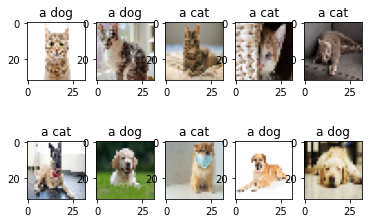

In [36]:
classes = ['dog','cat']

plt.figure()
f, axarr = plt.subplots(ncols=5, nrows=2) 

k = 0
for i in range(2):
    for j in range(5):
        axarr[i][j].imshow(np.uint8(img_arr[k]))      
        axarr[i][j].set_title("a "+classes[int(Y_labels[k])])
        k += 1

Copyright &copy; 2022 Marina Barsky. All rights reserved.